# Test for LHC (RW imp.): DELPHI calculations & comparison with PyHEADTAIL
Parameters from D. Amorim, talk at HSC section meeting, 17/06/2019

## Imports

In [1]:
%matplotlib notebook

In [2]:
import sys
sys.path.append('../IW2D/PYTHON_codes_and_scripts/General_Python_tools/')
sys.path.append('../IW2D/PYTHON_codes_and_scripts/Impedance_lib_Python/')
sys.path.append('../DELPHI/DELPHI_Python')
sys.path.append('../DELPHI/DELPHI')

In [3]:
from string import *
import time
import numpy as np
from copy import deepcopy
import os,re,shutil,json
#from io_lib import *
#from tables_lib import select_in_table
#from plot_lib import set_fontsize,scix,sciy
#from particle_param import *
from Impedance import *
from DELPHI import *
#from LHC_param import *
#from LHC_imp import *
#from LHC_coll_imp import *
import pickle as pkl
import inspect
#import pyoptics as opt
import csv
#from octupole import detuning_coeff,detuning_bx_bxy,find_octupole_threshold
from datetime import datetime
from collections import OrderedDict
from matplotlib import pyplot as plt
import warnings
from glob import glob
from pprint import pprint
from numpy import linalg as li
from scipy import optimize as op

warnings.simplefilter('ignore')

## Machine parameters

In [4]:
electron, m0, clight, E0 = 1.602176487e-19, 1.6726216e-27, 299792458, 1.5032773250670618e-10
machine = 'LHC'
mu0 = 4e-7*np.pi
Z0 = mu0*clight
print mu0,Z0

1.25663706144e-06 376.730313462


In [5]:
# flags and numerical parameters
flagdamperimp = 0 # 1 to use frequency dependent damper gain (provided in Zd,fd)
d = None
freqd = None
strnorm = ['']
flagnorm = 0 # 1 if damper matrix normalized at current chromaticity (instead of at zero chroma)
nevery = 1 # downsampling of the impedance (take less points than in the full model)
kmax = 1 # number of converged eigenvalues (kmax most unstable ones are converged)
kmaxplot = 200; # number of kept and plotted eigenvalues (in TMCI plot)
flagm0 = True
flageigenvect = False
queue = '2nd' # LXBATCH queue (converted in DELPHI to a ht_condor one)
# DELPHI convergence criteria
crit = 5e-3
abseps = 1e-4
ResultDir = './Example_RW'
ResultsFolderDELPHI = 'DELPHIrun'

In [6]:
circ=26658.8832 # total circumference in m
E = 6.5e12
gamma = E*electron/E0
beta=np.sqrt(1.-1./(gamma**2))
circ
print beta,gamma

0.9999999895816055 6927.62871617


## Impedance

<IPython.core.display.Javascript object>


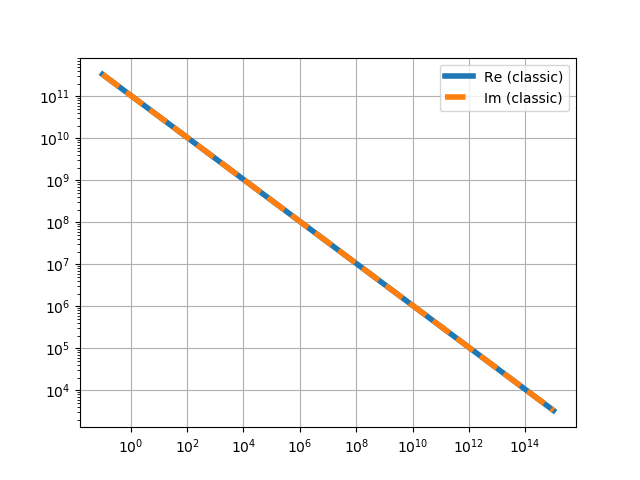

In [7]:
# classic thick wall
rho = 1.7e-8 # Ohm.m
length = circ
b = 0.01 # radius

freq = 10.**np.arange(-1,15.02,0.02)
omega = 2.*np.pi*freq

# classic thick wall formula
delta_skin = np.sqrt(2.*rho/(mu0*omega))
Zdip = length*Z0*delta_skin/(2.*np.pi*b**3)*beta
Zxdip = np.hstack((Zdip.reshape(-1,1),Zdip.reshape(-1,1)))

imp_mod_RW = [impedance_wake(a=1,b=0,c=0,d=0,plane='x',var=freq,func=Zxdip),
              impedance_wake(a=0,b=1,c=0,d=0,plane='y',var=freq,func=Zxdip)]

plt.figure()
plt.loglog(imp_mod_RW[0].var, imp_mod_RW[0].func[:,0], label='Re (classic)',lw=4.)
plt.loglog(imp_mod_RW[0].var, imp_mod_RW[0].func[:,1], '--',label='Im (classic)',lw=4.)
plt.legend()
plt.grid()

<IPython.core.display.Javascript object>


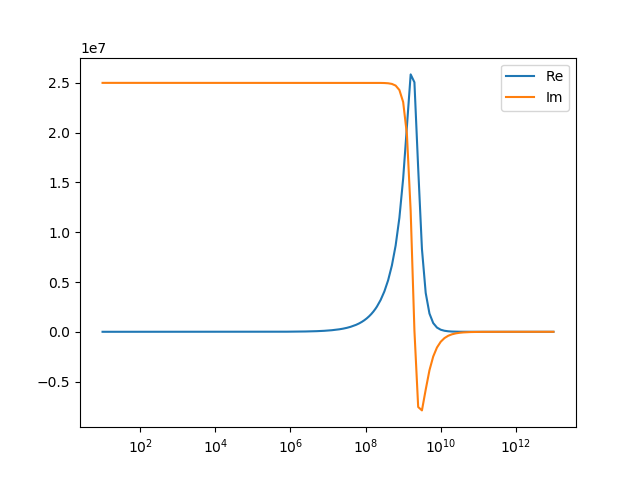

In [8]:
# Broad-band impedance
Rt = 25e6 # shunt impedance in MOhm/m
fr = 2e9 # cutoff frequency in Hz
Q = 1 # quality factor
imp_mod_NB, _ = imp_model_resonator(Rlist=Rt,frlist=fr,Qlist=Q,beta=beta,
                                 fpar=freq_param(fmin=10,fmax=1e13,ftypescan=2,
                                                 nflog=10,fminrefine=5e7,fmaxrefine=2e8,nrefine=200,fadded=[]),
                                 listcomp=['Zxdip'])

plt.figure()
plt.semilogx(imp_mod_NB[0].var, imp_mod_NB[0].func[:,0], label='Re')
plt.semilogx(imp_mod_NB[0].var, imp_mod_NB[0].func[:,1], label='Im')
plt.legend()
plt.show()

## Chromaticity scan - old DELPHI calculations

### Parameters

In [9]:
nevery = 1

planes = ['x']
dphase = 0.
Nbscan = np.arange(1e11, 10e11, 1e11) # bunch intensity
Mscan = np.array([1])
Qpscan = np.array([0])
dampscan = np.array([0.])

# deal with optics and parameters
R=circ/(2.*np.pi) # machine physical radius
Qx=62.31
Qxfrac=Qx-np.floor(Qx)
Qy=60.32
Qyfrac=Qy-np.floor(Qy)
alphap = 3.48e-4 # momentum compaction factor

E = 6.5e12
gamma=E*electron/E0
beta=np.sqrt(1.-1./(gamma**2))
f0=clight*beta/circ # rev. frequency
omega0=2.*np.pi*f0
eta=alphap-1./(gamma*gamma) # slip factor
print("gamma={}, beta={}".format(gamma,beta))

# longitudinal parameters
taub = 1e-9 # full bunch length
sigmaz = taub*clight*beta/4. # RMS bunch length (m)
Qs = 1.909e-3
typelong = 'Gaussian' # Longitudinal distribution
omegas=Qs*omega0
print("eta={}, Qs={}, taub={}, sigmaz={}".format(eta,Qs,taub,sigmaz))

# Longitudinal distribution decomposition nad average beta functions used
g, a, b = longdistribution_decomp(taub, typelong=typelong)
avbetax = R/Qx
avbetay = R/Qy

gamma=6927.62871617, beta=0.999999989582
eta=0.000347979163211, Qs=0.001909, taub=1e-09, sigmaz=0.0749481137192


### Calculations

In [11]:
reload(sys.modules['DELPHI'])
from DELPHI import *

In [12]:
ResultsFolderDELPHI = 'DELPHIrun'
scenario = "RW_Qpscan_DELPHI"
print scenario

# Initialize tune shifts
tuneshiftQp = np.zeros((len(planes),len(Mscan),len(Qpscan),len(dampscan),len(Nbscan),1,1,kmaxplot), dtype=complex)
tuneshiftm0Qp = np.zeros((len(planes),len(Mscan),len(Qpscan),len(dampscan),len(Nbscan),1,1), dtype=complex)

print 'DELPHI, RW Qpscan computation'
result_folder = os.path.join(ResultDir,scenario,ResultsFolderDELPHI)
os.system("mkdir -p "+result_folder)

# DELPHI run

t0 = ti.clock()
(tuneshiftQp[:,:,:,:,:,:,:,:],
 tuneshiftm0Qp[:,:,:,:,:,:,:]) = DELPHI_wrapper(imp_mod_NB, Mscan, Qpscan, dampscan, Nbscan,
                                                          [omegas], [dphase], omega0, Qx, Qy, gamma, eta, a, b, taub, g,
                                                          planes, nevery=nevery, particle='proton', flagnorm=flagnorm,
                                                          flagdamperimp=flagdamperimp, d=d, freqd=freqd, kmax=kmax, kmaxplot=kmaxplot,
                                                          crit=crit, abseps=abseps, flagm0=flagm0, flageigenvect=flageigenvect,
                                                          lxplusbatch=None, comment="{}_{}".format(machine,scenario),
                                                          queue=queue, dire=result_folder+'/', flagQpscan_outside=True,
                                                          optimized_convergence=True)
t1 = ti.clock()
print("Elapsed time={} s".format(t1-t0))

# Output files name for data vs Qp
E = gamma*E0/electron
Estr = float_to_str(round(E/1e9))+'GeV'
with open(os.path.join(result_folder,'Qs.txt'),'w') as f:
    f.write("{}\n".format(Qs))
np.save(os.path.join(result_folder,'TuneshiftQp.npy'), tuneshiftQp[:,:,:,:,:,:,:,:])
np.save(os.path.join(result_folder,'Tuneshiftm0Qp.npy'), tuneshiftm0Qp[:,:,:,:,:,:,:])

strpart=['Re','Im']


RW_Qpscan_DELPHI
DELPHI, RW Qpscan computation
lmax= 1 , nmax= 1 , time for eigenvalue pb resolution [seconds]:  0.000145
lmax= 2 , nmax= 1 , time for eigenvalue pb resolution [seconds]:  0.000132000000001
lmax= 2 , nmax= 2 , time for eigenvalue pb resolution [seconds]:  0.000163999999998
lmax= 1 , nmax= 1 , time for eigenvalue pb resolution [seconds]:  4.69999999986e-05
lmax= 2 , nmax= 1 , time for eigenvalue pb resolution [seconds]:  0.000112000000001
lmax= 2 , nmax= 2 , time for eigenvalue pb resolution [seconds]:  0.000154000000002
lmax= 1 , nmax= 1 , time for eigenvalue pb resolution [seconds]:  5.00000000017e-05
lmax= 2 , nmax= 1 , time for eigenvalue pb resolution [seconds]:  0.000114999999994
lmax= 2 , nmax= 2 , time for eigenvalue pb resolution [seconds]:  0.000139999999995
lmax= 1 , nmax= 1 , time for eigenvalue pb resolution [seconds]:  4.50000000001e-05
lmax= 2 , nmax= 1 , time for eigenvalue pb resolution [seconds]:  0.000108000000004
lmax= 2 , nmax= 2 , time for eigenvalu

In [ ]:
print np.squeeze(tuneshiftQp)[:10]

In [ ]:
plt.figure()
plt.plot(Nbscan, np.squeeze(tuneshiftQp), '.')